Import the necessary libraries and modules.

In [106]:
import pandas as pd
import numpy as np
import csv
import ast
import matplotlib.pyplot as plt
import io

Change the Path variable to point to your CSV file

In [107]:
path = r"C:\Users\joacosta\Work\Beumer\NortFord\Data Analitics\Extracted\Log Monitor\09-23-2025\SO4_From_1510_To_1640_Sep_23_2025.csv"

In [108]:
raw_df = pd.read_csv(
    path,
    sep=";",
    header=None,
    engine="python",
    quoting=csv.QUOTE_NONE,
    skipinitialspace=True,
    on_bad_lines="skip",
    dtype=str
)

# Cleaning dataset

In [109]:
df_no_quotation = raw_df.replace('"', '', regex=True)
# Rename original df columns
df_no_quotation.columns = [
    "timeStamp", "flag", "systemName", "ipAddress", "sender", "unkown",
    "unkown_2", "PLCTimeStamp", "machineCode", "unitID", "sequenceNo",
    "rawMessage"
]

df_no_quotation["rawMessage"] = df_no_quotation["rawMessage"].str.removeprefix("->{").str.removesuffix("}<")

def split_key_values(text):
    parts = []
    buf = ""
    inside_brackets = 0
    
    for ch in text:
        if ch == "[":
            inside_brackets += 1
        elif ch == "]":
            inside_brackets -= 1
        
        if ch == "," and inside_brackets == 0:
            parts.append(buf.strip())
            buf = ""
        else:
            buf += ch
    if buf:
        parts.append(buf.strip())
    return parts

def parse_row(text):
    items = split_key_values(text)
    d = {}
    for item in items:
        if ":" in item:
            k, v = item.split(":", 1)
            d[k.strip()] = v.strip()
    return d

df_expanded = df_no_quotation["rawMessage"].apply(parse_row).apply(pd.Series)

# Function to parse array-like strings and return the first element
def first_element(val):
    if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
        try:
            # Try to parse safely into Python list
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except (ValueError, SyntaxError):
            # If literal_eval fails (e.g. strings without quotes like [Used,FromAwcs])
            parts = [x.strip() for x in val.strip("[]").split(",")]
            return parts[0] if parts else val
    return val

# Apply to your target columns
for col in ["requestedDestMCID", "sortCode", "requestedDestStatus"]:
    df_expanded[col] = df_expanded[col].apply(first_element)

# Drop the old structured column
df_temp = df_no_quotation.drop(columns=["rawMessage"])

# Merge with expanded dataframe
df_clean = pd.concat([df_temp, df_expanded], axis=1)

df_clean.head(10)

,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType
0,250923 152653 518,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:13,807",MC01,54177,...,1344,S01ab,SD0010GOOD_001_v,169,169,0,Used,AwcsConverterMcIf,Send,S04
1,250923 152655 436,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:15,725",MC01,54177,...,1345,S01ab,SD0007GOOD_001_v,177,177,0,Used,AwcsConverterMcIf,Send,S04
2,250923 152656 407,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:16,695",MC01,54177,...,1346,S01ab,SD0007GOOD_001_v,181,181,0,Used,AwcsConverterMcIf,Send,S04
3,250923 152657 407,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:17,653",MC01,54177,...,1347,S01ab,SD0006GOOD_001_v,185,185,0,Used,AwcsConverterMcIf,Send,S04
4,250923 152658 571,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:18,856",MC01,54177,...,1348,S01ab,SD0007GOOD_001_v,189,189,0,Used,AwcsConverterMcIf,Send,S04
5,250923 152659 518,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:19,807",MC01,54177,...,1349,S01ab,SD0007GOOD_001_v,159,159,0,Used,AwcsConverterMcIf,Send,S04
6,250923 152700 720,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:21,013",MC01,54177,...,1350,S01ab,SD0004GOOD_001_v,197,197,0,Used,AwcsConverterMcIf,Send,S04
7,250923 152701 435,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:21,725",MC01,54177,...,1352,S01ab,SD0006GOOD_001_v,201,201,0,Used,AwcsConverterMcIf,Send,S04
8,250923 152702 663,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:22,934",MC01,54177,...,1354,S01ab,SD0007GOOD_001_v,205,205,0,Used,AwcsConverterMcIf,Send,S04
9,250923 152704 101,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"03:08:24,373",MC01,54177,...,1351,S01ab,SD0004GOOD_001_v,209,209,0,Used,AwcsConverterMcIf,Send,S04


Removing bad packages that just produce noise in the results

In [110]:
print(df_clean["indexNo"].dtype)

object


# Purge IDs from the Scanners

Purge Some IDs for the Scanner because they are not Scan defects, because those packages doesnt have a label on it.

In [111]:
# # ids to remove (strings, with leading zeros)
# bad_ids = ['0007', '0009', '0011', '0012', '0016', '0018', '0058', '0061', '0063', '0071', '0074', '0092', '0100', '0105', '0124', '0156', '0159', '0176', '0183', '0208', '0221', '0223', '0225', '0231', '0235', '0236', '0245', '0249', '0272', '0273', '0391', '0394', '0398', '0401', '0402', '0409', '0420', '0421', '0441', '0446', '0448', '0466', '0485', '0493', '0514', '0518', '0521', '0569', '0616', '0645', '0705', '0723', '0803', '0805', '0806', '0817', '0870', '0886', '0940', '0966', '0968', '0980', '1006', '1009', '1015', '1031', '1045', '1057', '1073', '1076', '1087', '1098', '1132', '1150', '1155', '1169', '1175', '1186', '1197', '1213', '1239', '1258', '1260', '1294', '1324', '1332', '1336', '1348', '1359', '1396', '1415', '1417', '1432', '1436', '1451', '1473', '1493', '1521', '1539', '1583', '1609', '1650', '1687', '1692', '1701', '1707', '1708', '1717', '1750', '1811', '1814', '1820', '1821', '1826', '1842', '1846', '1850', '1853', '1899', '1920', '1956', '1974', '1975', '1980', '1983', '1985', '1986', '1997', '0299', '0411', '0468','0544','1018','1160','0261','0389']
# bad_set = set(bad_ids)

# # identify matching rows and update reasonCode to 0
# mask = df_clean["indexNo"].isin(bad_set)
# matched_ids = df_clean.loc[mask, "indexNo"].dropna().unique().tolist()
# modified_count = mask.sum()

# # set sortCode to 0 for matching rows
# df_clean.loc[mask, "sortCode"] = 0

# not_found = sorted(list(bad_set.difference(matched_ids)))
# print(f"Modified sortCode to 0 for {modified_count} rows by exact string match on indexNo.")
# if matched_ids:
#     print("IDs modified:", matched_ids)
# if not_found:
#     print("IDs not found (no rows matched):", not_found)


In [112]:
# # read the CSV file
# bad_ids_df = pd.read_csv(r"C:\Users\joacosta\Work\Beumer\NortFord\Data Analitics\Excel Reports\09-24-2025\Critical Test\VS_B\Second Test\SecondTestFalsePositiveScanDefects.csv")

# # get the column name automatically (first column only)
# col_name = bad_ids_df.columns[0]

# # extract IDs, convert to string, and pad with leading zeros up to 4 digits
# bad_ids = bad_ids_df[col_name].dropna().astype(int).astype(str).str.zfill(4).tolist()
# bad_set = set(bad_ids)

# # identify matching rows and update reasonCode to 0
# mask = df_clean["indexNo"].isin(bad_set)
# matched_ids = df_clean.loc[mask, "indexNo"].dropna().unique().tolist()
# modified_count = mask.sum()

# # set sortCode to 0 for matching rows
# df_clean.loc[mask, "sortCode"] = 0

# # check which IDs from bad_ids were not found
# not_found = sorted(list(bad_set.difference(matched_ids)))
# print(f"Modified sortCode to 0 for {modified_count} rows by exact string match on indexNo.")
# if matched_ids:
#     print("IDs modified:", matched_ids)
# if not_found:
#     print("IDs not found (no rows matched):", not_found)


In [ ]:

# Read CSV (first = IDs, second = comments)
bad_ids_df = pd.read_csv(r"C:\Users\joacosta\Work\Beumer\NortFord\Data Analitics\Extracted\Log Monitor\09-23-2025\New Window\False_Positive_Scan _Defects_List.csv")

# get the column names automatically (first two columns)
id_col_name = bad_ids_df.columns[0]  # ID column
comment_col_name = bad_ids_df.columns[1]  # Comment column

# create a dictionary mapping IDs to comments
id_comment_dict = {}
for _, row in bad_ids_df.iterrows():
    if pd.notna(row[id_col_name]):  # only process non-null IDs
        # convert ID to padded string format
        padded_id = str(int(row[id_col_name])).zfill(4)
        comment = row[comment_col_name] if pd.notna(row[comment_col_name]) else ""
        id_comment_dict[padded_id] = comment

# extract IDs from the dictionary
bad_ids = list(id_comment_dict.keys())
bad_set = set(bad_ids)

# add the new column to df_clean if it doesn't exist
if "No Scan Defect Explanation" not in df_clean.columns:
    df_clean["No Scan Defect Explanation"] = ""

# identify matching rows and update both sortCode and the explanation column
mask = df_clean["indexNo"].isin(bad_set)
matched_ids = df_clean.loc[mask, "indexNo"].dropna().unique().tolist()
modified_count = mask.sum()

# set sortCode to 0 for matching rows
df_clean.loc[mask, "sortCode"] = 0

# add comments to the explanation column for matching rows
for idx in df_clean.index[mask]:
    index_no = df_clean.loc[idx, "indexNo"]
    if index_no in id_comment_dict:
        df_clean.loc[idx, "No Scan Defect Explanation"] = id_comment_dict[index_no]

# check which IDs from bad_ids were not found
not_found = sorted(list(bad_set.difference(matched_ids)))

print(f"Modified sortCode to 0 for {modified_count} rows by exact string match on indexNo.")
if matched_ids:
    print("IDs modified:", matched_ids)
    print("Comments added to 'No Scan Defect Explanation' column")
if not_found:
    print("IDs not found (no rows matched):", not_found)


In [114]:
df_clean.shape

(7285, 24)

In [115]:
df_clean.nunique()

timeStamp              7244
flag                      1
systemName                1
ipAddress                 1
sender                    1
unkown                    1
unkown_2                  1
PLCTimeStamp           7250
machineCode               1
unitID                    1
sequenceNo              256
event                     1
plcRecordNo            1999
itemID                 7025
indexNo                1999
locationAWCS              2
barcodeAWCS              12
actualDestMCID           17
requestedDestMCID        16
sortCode                  4
requestedDestStatus       1
comHost                   1
comMode                   1
telegramType              1
dtype: int64

In [116]:
# Get list of columns with only 1 unique value
cols_to_drop = df_clean.columns[df_clean.nunique() == 1].tolist()

print("Columns to drop:", cols_to_drop)

df_reduced = df_clean.drop(columns=cols_to_drop)

print("Remaining columns:", df_reduced.columns.tolist())
df_reduced.head()


Columns to drop: ['flag', 'systemName', 'ipAddress', 'sender', 'unkown', 'unkown_2', 'machineCode', 'unitID', 'event', 'requestedDestStatus', 'comHost', 'comMode', 'telegramType']
Remaining columns: ['timeStamp', 'PLCTimeStamp', 'sequenceNo', 'plcRecordNo', 'itemID', 'indexNo', 'locationAWCS', 'barcodeAWCS', 'actualDestMCID', 'requestedDestMCID', 'sortCode']


,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode
0,250923 152653 518,"03:08:13,807",SQ 002,1344,25332U,1344,S01ab,SD0010GOOD_001_v,169,169,0
1,250923 152655 436,"03:08:15,725",SQ 082,1345,25333U,1345,S01ab,SD0007GOOD_001_v,177,177,0
2,250923 152656 407,"03:08:16,695",SQ 132,1346,25334U,1346,S01ab,SD0007GOOD_001_v,181,181,0
3,250923 152657 407,"03:08:17,653",SQ 172,1347,25335U,1347,S01ab,SD0006GOOD_001_v,185,185,0
4,250923 152658 571,"03:08:18,856",SQ 220,1348,25336U,1348,S01ab,SD0007GOOD_001_v,189,189,0


In [117]:
# Dictionary for mapping sort codes
sort_code_map = {
    0: "Success",
    1: "Unknown",
    2: "Unexpected_Container",
    3: "Tracking_Error",
    4: "Gap_Error",
    5: "Destination_Full",
    6: "Destination_Non_Operational",
    7: "Invalid_Destination",
    8: "No_Read",
    9: "No_Code",
    10: "Multi_Label",
    11: "<reserved>",
    12: "Destination_Disabled",
    13: "Throughput_Limit",
    14: "Failed_To_Divert",
    15: "<reserved>",
    16: "No_Destination_Received",
    17: "Lost_Container",
    18: "Dimension_Error",
    19: "Weight_Error",
    20: "Container_Utilization",
    21: "Unable_To_Divert",
    22: "Destination_Not_Attempted"
}
# Add a new column for description
df_reduced["sortReason"] = df_reduced["sortCode"].map(sort_code_map)


In [118]:
df_reduced.head()

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,sortReason
0,250923 152653 518,"03:08:13,807",SQ 002,1344,25332U,1344,S01ab,SD0010GOOD_001_v,169,169,0,Success
1,250923 152655 436,"03:08:15,725",SQ 082,1345,25333U,1345,S01ab,SD0007GOOD_001_v,177,177,0,Success
2,250923 152656 407,"03:08:16,695",SQ 132,1346,25334U,1346,S01ab,SD0007GOOD_001_v,181,181,0,Success
3,250923 152657 407,"03:08:17,653",SQ 172,1347,25335U,1347,S01ab,SD0006GOOD_001_v,185,185,0,Success
4,250923 152658 571,"03:08:18,856",SQ 220,1348,25336U,1348,S01ab,SD0007GOOD_001_v,189,189,0,Success


# Time Window

In [119]:
# Split into parts
parts = df_reduced["timeStamp"].str.split(" ", expand=True)
date_part = parts[0]     # YYMMDD
time_part = parts[1]     # HHMMSS
ms_part   = parts[2]     # milliseconds

# Build datetime string
datetime_str = date_part + time_part + ms_part
df_reduced["parsed_time"] = pd.to_datetime(
    datetime_str,
    format="%y%m%d%H%M%S%f",
    errors="coerce"
)

# filter window
start = pd.to_datetime("2025-09-23 15:32:00")
end   = pd.to_datetime("2025-09-23 16:02:00")

# check limits
data_min = df_reduced["parsed_time"].min()
data_max = df_reduced["parsed_time"].max()

if start < data_min or end > data_max:
    raise ValueError(
        f"Window [{start} → {end}] is outside of data range "
        f"[{data_min} → {data_max}]"
    )

# filter
window_df = df_reduced.loc[
    df_reduced["parsed_time"].between(start, end)
].reset_index(drop=True)




In [120]:
window_df.head(1)

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,sortReason,parsed_time
0,250923 153200 283,"03:13:20,539",SQ 210,0016,26003U,0016,S01ab,SD0004GOOD_001_v,177,177,0,Success,2025-09-23 15:32:00.283


In [121]:
window_df.tail(1)

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,sortReason,parsed_time
4015,250923 160159 870,"03:43:20,139",SQ 229,1867,29853U,1867,S01ab,??????????,159,159,8,No_Read,2025-09-23 16:01:59.870


# Group By Process

In [122]:
# Count items by sortReason
sort_counts = window_df.groupby("sortReason").size().reset_index(name="count")

print(sort_counts)

         sortReason  count
0  Destination_Full     26
1       Multi_Label     32
2           No_Read     44
3           Success   3914


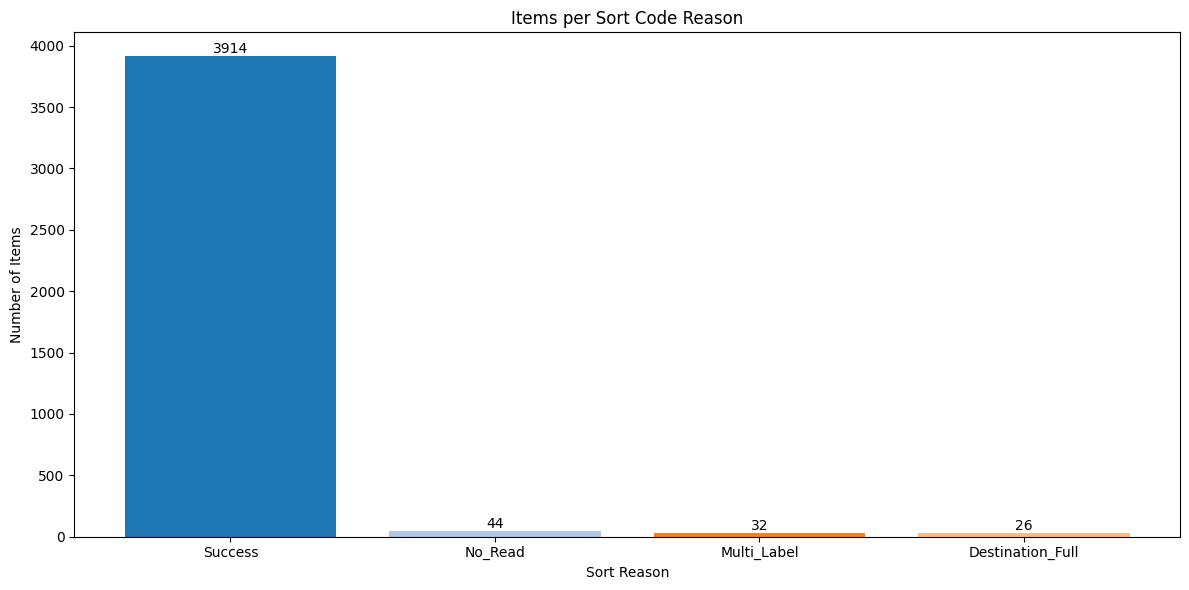

In [123]:
# Sort counts by frequency (optional, looks nicer)
sort_counts = sort_counts.sort_values("count", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(sort_counts["sortReason"], sort_counts["count"], color=plt.cm.tab20.colors) # type: ignore[attr-defined]

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # X position (center of bar)
        height,                            # Y position (just above the bar)
        str(height),                       # Text = count value
        ha="center", va="bottom", fontsize=10
    )

plt.title("Items per Sort Code Reason")
plt.xlabel("Sort Reason")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

# MHE KPIs Analysis

In [124]:
# Map each reason to its category
defect_category_map = {
    # Scan Defect
    "Multi_Label": "Scan Defect",
    "No_Read": "Scan Defect",
    "No_Code": "Scan Defect",

    # MHE Defect
    "Failed_To_Divert": "MHE Defect",
    "Gap_Error": "MHE Defect",
    "Destination_Non_Operational": "MHE Defect",  # Lane_Non_Operational in doc
    "Lost_Container": "MHE Defect",
    "No_Destination_Received": "MHE Defect",
    "Unknown": "MHE Defect",   # Sort_Unknown in doc
    "Tracking_Error": "MHE Defect",
    "Unable_To_Divert": "MHE Defect",
}


In [125]:
# Map defect category
window_df["defectCategory"] = window_df["sortReason"].map(defect_category_map)

# Total packages processed (all rows)
total_processed = len(window_df)

# Count defects only (exclude NaN)
defect_summary = (
    window_df["defectCategory"]
    .value_counts(dropna=True)
    .rename_axis("defectCategory")
    .reset_index(name="count")
)

# Percent over total processed
defect_summary["percentage"] = 100 * defect_summary["count"] / total_processed

# Optional: nicer formatting
defect_summary["percentage"] = defect_summary["percentage"].round(2)

print(defect_summary)


  defectCategory  count  percentage
0    Scan Defect     76        1.89


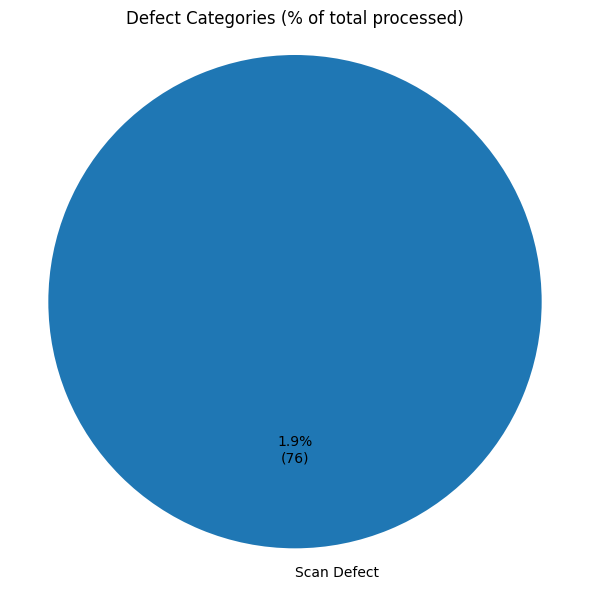

In [126]:
import matplotlib.pyplot as plt

labels = defect_summary["defectCategory"].tolist()
counts = defect_summary["count"].to_numpy()

total_defects = counts.sum()
total_processed = len(window_df)

cmap = plt.get_cmap("tab10")
colors = [cmap(x) for x in np.linspace(0, 1, len(labels))]

def autopct_total(pct_defect_space):
    # recover the absolute count of the wedge
    count = int(round(pct_defect_space * total_defects / 100.0))
    pct_of_total = 100.0 * count / total_processed if total_processed else 0.0
    return f"{pct_of_total:.1f}%\n({count})"

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=labels,
    autopct=autopct_total,      # labels show % of ALL processed
    startangle=90,
    colors=colors
)
plt.title("Defect Categories (% of total processed)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [127]:
# Filter for sortCode 8 and 10
filtered_df = window_df[window_df['sortCode'].isin([8, 10])]

# Create a new dataset with just the columns we need
export_df = filtered_df[['indexNo', 'timeStamp', 'sortCode']].copy()

# Sort by timeStamp for better organization
export_df = export_df.sort_values('timeStamp')

# Print the results
print(f"Found {len(export_df)} items with sortCode 8 or 10:")
print("\nIndexNo and TimeStamp for sortCode 8 and 10:")
print(export_df.to_string(index=False))

# Export to Excel
output_path = r"C:\Users\joacosta\Work\Beumer\NortFord\Python\ORF5\data\sortcode_8_10_analysis.xlsx"
export_df.to_excel(output_path, index=False, sheet_name='SortCode_8_10')

print(f"\nData exported to: {output_path}")

# Optional: Show breakdown by sortCode
print("\nBreakdown by sortCode:")
print(export_df['sortCode'].value_counts().sort_index())

Found 76 items with sortCode 8 or 10:

IndexNo and TimeStamp for sortCode 8 and 10:
indexNo         timeStamp  sortCode
   0036 250923 153215 136        10
   0046 250923 153215 390         8
   0071 250923 153233 128         8
   0126 250923 153249 952        10
   0183 250923 153321 872         8
   0282 250923 153402 196        10
   0347 250923 153426 421        10
   0364 250923 153440 108        10
   0390 250923 153449 939         8
   0525 250923 153544 207         8
   0537 250923 153550 662        10
   0541 250923 153558 377        10
   0599 250923 153620 912         8
   0592 250923 153621 388         8
   0608 250923 153621 910         8
   0595 250923 153622 385         8
   0609 250923 153622 826         8
   0598 250923 153623 600         8
   0607 250923 153624 289         8
   0601 250923 153624 750         8
   0622 250923 153634 105        10
   0647 250923 153642 269         8
   0740 250923 153728 349        10
   0743 250923 153732 447        10
   0968 250923 1

# Write to excel file

In [128]:
total_processed = len(window_df)

defect_summary = (
    window_df["defectCategory"]
    .value_counts(dropna=True)
    .rename_axis("defectCategory")
    .reset_index(name="count")
)

# % over ALL processed, not just defects
defect_summary["percentage"] = (
    100 * defect_summary["count"] / total_processed
).round(2)

labels = defect_summary["defectCategory"].tolist()
counts = defect_summary["count"].to_numpy()

no_defect_count = max(total_processed - counts.sum(), 0)
labels_all = labels + ["No Defect"]
counts_all = np.append(counts, no_defect_count)

cmap = plt.get_cmap("tab10")
colors = [cmap(x) for x in np.linspace(0, 1, len(labels_all))]

def autopct_if_big(p):
    # write % on wedge only if >= 2% to avoid clutter
    return f"{p:.1f}%" if p >= 2 else ""

fig1, ax1 = plt.subplots(figsize=(8, 6))  # wider to fit legend
wedges, texts, autotexts = ax1.pie(
    counts_all,
    startangle=90,
    colors=colors,
    autopct=autopct_if_big,
    pctdistance=0.75,
    textprops={"fontsize": 10},
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
)

# Donut hole
ax1.add_artist(plt.Circle((0, 0), 0.55, fc="white"))
ax1.set_title("Package Outcomes (Defects vs No Defect)")
ax1.axis("equal")

# Legend on the right
total_all = counts_all.sum()
legend_labels = [
    f"{lbl} — {cnt} ({(cnt/total_all*100):.1f}%)"
    for lbl, cnt in zip(labels_all, counts_all)
]
ax1.legend(
    wedges, legend_labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)
plt.tight_layout()

# Save pie image to buffer for Excel
buf_pie = io.BytesIO()
fig1.savefig(buf_pie, format="png", dpi=150, bbox_inches="tight")
plt.close(fig1)
buf_pie.seek(0)

# =========================================================
# 3) sortReason counts + BAR chart
# =========================================================
sort_counts = (
    window_df["sortReason"]
    .value_counts(dropna=False)  # keep NaNs as their own entry
    .rename_axis("sortReason")
    .reset_index(name="count")
).sort_values("count", ascending=False).reset_index(drop=True)

fig2, ax2 = plt.subplots(figsize=(12, 6))
cmap2 = plt.get_cmap("tab20")
colors2 = [cmap2(i / max(1, len(sort_counts) - 1)) for i in range(len(sort_counts))]

bars = ax2.bar(
    sort_counts["sortReason"].astype(str).tolist(),
    sort_counts["count"].to_numpy(),
    color=colors2
)
for b in bars:
    h = b.get_height()
    ax2.text(b.get_x() + b.get_width()/2, h, str(int(h)), ha="center", va="bottom", fontsize=10)

ax2.set_title("Items per Sort Code Reason")
ax2.set_xlabel("Sort Reason")
ax2.set_ylabel("Number of Items")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save bar image to buffer for Excel
buf_bar = io.BytesIO()
fig2.savefig(buf_bar, format="png", dpi=150, bbox_inches="tight")
plt.close(fig2)
buf_bar.seek(0)

# =========================================================
# 4) Write everything into Excel with generous spacing
# =========================================================
# out_path = "analysis_output.xlsx"
start_str = start.strftime("%Y%m%d-%H%M%S")
end_str   = end.strftime("%Y%m%d-%H%M%S")
out_path = f"SO4_{start_str}_{end_str}.xlsx"


with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    # Analysis_Results (create + header)
    pd.DataFrame().to_excel(writer, sheet_name="Analysis_Results", index=False)
    wb = writer.book
    ws = writer.sheets["Analysis_Results"]
    bold = wb.add_format({"bold": True})  # type: ignore[attr-defined]

    ws.write("A1", "Analysis Summary", bold)
    ws.write("A3", "Total records (window dataset):")
    ws.write_number("B3", len(window_df))
    ws.write("C3", "Time window:")
    ws.write("D3", "StartTime:")
    ws.write("E3", start.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3])  # trim to milliseconds
    ws.write("F3", "EndTime:")
    ws.write("G3", end.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3])    # trim to milliseconds

    # Defect summary table
    ws.write("A5", "Defect Category Breakdown (percent over ALL processed)", bold)
    defect_summary.to_excel(writer, sheet_name="Analysis_Results", startrow=6, startcol=0, index=False)
    ws.set_column("A:A", 22)
    ws.set_column("B:B", 12)
    ws.set_column("C:C", 14)

    # Insert PIE at D3 with small offset
    ws.insert_image("D3", "defect_pie.png", {
        "image_data": buf_pie,
        "x_offset": 10, "y_offset": 5,
        # "x_scale": 0.95, "y_scale": 0.95,  # optional
    })

    # Sort table
    start_row_sort = 6 + len(defect_summary) + 3
    ws.write(start_row_sort - 1, 0, "Sort Code Reason Counts", bold)
    sort_counts.to_excel(writer, sheet_name="Analysis_Results", startrow=start_row_sort, startcol=0, index=False)
    ws.set_column("A:A", 30)
    ws.set_column("B:B", 14)

    # Insert BAR far to the right (column L = index 11) with offsets
    ws.insert_image(start_row_sort - 1, 11, "sort_reason_bar.png", {
        "image_data": buf_bar,
        "x_offset": 20, "y_offset": 5,
        # "x_scale": 0.9, "y_scale": 0.9,    # optional
    })

    # Raw/Clean data sheets
    raw_df.to_excel(writer, sheet_name="Raw_Data", index=False)
    window_df.to_excel(writer, sheet_name="Clean_Data", index=False)

print(f"Saved: {out_path}")


Saved: SO4_20250923-153200_20250923-160200.xlsx
